## 기본 환경 설정

In [1]:
%load_ext autotime

time: 132 µs (started: 2023-05-12 16:12:18 +09:00)


In [44]:
import sshtunnel
import os
import mysql.connector
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import json
import ast

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 1000)
plt.rcParams['figure.figsize'] = [15, 15]
plt.rcParams['font.size'] = 15
sns.set(color_codes=True)
sns.set(font_scale=1.5)
sns.set_palette("bright")
sns.set_style("whitegrid")


time: 1.87 ms (started: 2023-05-12 16:43:39 +09:00)


In [3]:
VM_INS = '144.24.89.218'
VM_USER = 'opc'
VM_SSHKEY = '/Users/khkwon01/회사/회사업무/개인테스트/id_rsa'
DB_IP = '10.0.20.156'
DB_USER = 'admin'
DB_PASS = 'Welcome#1'
DB_SCHEMA = 'census'
DEBUG = True


time: 669 µs (started: 2023-05-12 16:21:57 +09:00)


## MDS와 SSH 터널링 연결

In [4]:
tunnel = sshtunnel.SSHTunnelForwarder(
    (VM_INS, 22),
    ssh_username=VM_USER,
    ssh_pkey=VM_SSHKEY,
    remote_bind_address=(DB_IP, 3306)
)
tunnel.start()
tunnel.is_active

True

time: 419 ms (started: 2023-05-12 16:22:01 +09:00)


In [5]:
mydb = mysql.connector.connect (
    host="127.0.0.1",
    port=tunnel.local_bind_port,
    user=DB_USER,
    password=DB_PASS,
    database=DB_SCHEMA,
    allow_local_infile=True,
    use_pure=True
)
cursor = mydb.cursor()

def execute_sql(sql):
    if DEBUG:
        print(f'Running {sql}')
    cursor.execute(sql)

    return pd.DataFrame(cursor.fetchall(), columns=cursor.column_names)

time: 246 ms (started: 2023-05-12 16:22:05 +09:00)


## MDS DB 버전 확인

In [6]:
execute_sql(f"""select version()""")

Running select version()


,version()
0,8.0.33-u2-cloud


time: 66.1 ms (started: 2023-05-12 16:22:10 +09:00)


In [7]:
execute_sql(f"""describe census_train""")

Running describe census_train


,Field,Type,Null,Key,Default,Extra
0,age,int,YES,,None,
1,workclass,varchar(255),YES,,None,
2,fnlwgt,int,YES,,None,
3,education,varchar(255),YES,,None,
4,education-num,int,YES,,None,
5,marital-status,varchar(255),YES,,None,
6,occupation,varchar(255),YES,,None,
7,relationship,varchar(255),YES,,None,
8,race,varchar(255),YES,,None,
9,sex,varchar(255),YES,,None,


time: 25.1 ms (started: 2023-05-12 16:22:14 +09:00)


## census trainning 데이터 확인

In [8]:
data = execute_sql(f"""select * from census_train""")
data.head()

Running select * from census_train


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,revenue
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K


time: 1.51 s (started: 2023-05-12 16:22:19 +09:00)


In [11]:
# data 값중 null 값이 있는지 체크
print(data.isnull().sum().count, data.isna().sum().count)

<bound method Series.count of age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
revenue           0
dtype: int64> <bound method Series.count of age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
revenue           0
dtype: int64>
time: 65 ms (started: 2023-05-12 16:22:49 +09:00)


## 컬럼별 데이터 분포 확인

In [46]:
# 근무종류별 데이터 분포 확인
labels = data['workclass'].value_counts().index
values = data['workclass'].value_counts().values
colors = data['workclass']

fig = px.pie(data['workclass'], values=values, names=labels, width=500, height=500, title='근무종류')
fig.show()

time: 79.9 ms (started: 2023-05-12 16:44:54 +09:00)


In [49]:
# 나이별 데이터 분포 확인
labels = data['age'].value_counts()[:10].index
values = data['age'].value_counts()[:10].values
colors = data['age']

fig = px.pie(data['age'], values=values, names=labels, labels=labels, width=500, height=500, title='나이')
fig.show()

time: 23.4 ms (started: 2023-05-12 16:46:43 +09:00)


In [50]:
# revenue 값에 대한 분포 확인
ct = execute_sql(f"""select revenue from census_train""").apply(pd.value_counts)
#ct.plot(kind='bar', color='b', alpha=0.5)

Running select revenue from census_train
time: 195 ms (started: 2023-05-12 16:48:38 +09:00)


<AxesSubplot: >

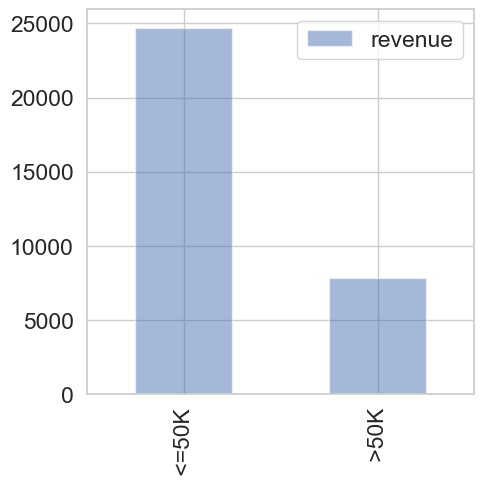

time: 430 ms (started: 2023-05-12 16:48:52 +09:00)


In [51]:
ct.plot(kind='bar', color='b', alpha=0.5, figsize=(5,5))

<AxesSubplot: ylabel='revenue'>

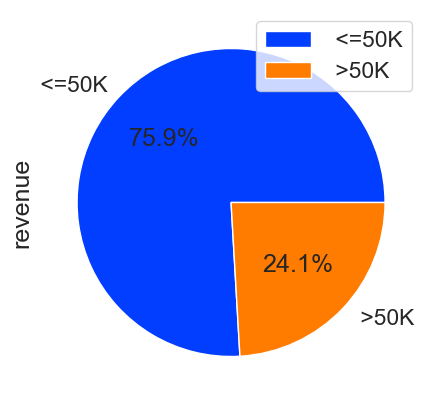

time: 79.2 ms (started: 2023-05-12 16:48:57 +09:00)


In [52]:
ct.plot(kind="pie", y='revenue', autopct='%1.1f%%', figsize=(5,5))

## ML 데이터 training 수행

In [53]:
execute_sql(f"""set @census_model = NULL;""")
execute_sql(f"""call sys.ML_TRAIN('census.census_train', 'revenue', JSON_OBJECT('task', 'classification'), @census_model);""")
#execute_sql(f"""SET @census_model = (SELECT model_handle FROM ML_SCHEMA_admin.MODEL_CATALOG ORDER BY model_id DESC LIMIT 1);""")

Running set @census_model = NULL;
Running call sys.ML_TRAIN('census.census_train', 'revenue', JSON_OBJECT('task', 'classification'), @census_model);


""


time: 2min 7s (started: 2023-05-12 16:49:03 +09:00)


In [54]:
execute_sql(f"""call sys.ML_MODEL_LOAD(@census_model, NULL);""")

Running call sys.ML_MODEL_LOAD(@census_model, NULL);


""


time: 800 ms (started: 2023-05-12 16:53:21 +09:00)


In [55]:
execute_sql(f"""select @census_model;""")

Running select @census_model;


,@census_model
0,census.census_train_admin_1683877743


time: 32.8 ms (started: 2023-05-12 16:53:24 +09:00)


## 훈련된 ML 모델 확인

In [56]:
execute_sql(f"""select * from ML_SCHEMA_{DB_USER}.MODEL_CATALOG where model_handle = @census_model;""")

Running select * from ML_SCHEMA_admin.MODEL_CATALOG where model_handle = @census_model;


,model_id,model_handle,model_type,task,model_owner,build_timestamp,target_column_name,train_table_name,column_names,model_explanation,last_accessed,model_object_size,notes,model_metadata
0,1,census.census_train_admin_1683877743,LGBMClassifier,classification,admin,1683877870,revenue,census.census_train,"{""0"": ""age"", ""1"": ""workclass"", ""2"": ""fnlwgt"", ""3"": ""education"", ""4"": ""education-num"", ""5"": ""marital-status"", ""6"": ""occupation"", ""7"": ""relationship"", ""8"": ""race"", ""9"": ""sex"", ""10"": ""capital-gain"", ""11"": ""capital-loss"", ""12"": ""hours-per-week"", ""13"": ""native-country""}","{""permutation_importance"": {""age"": 0.0356, ""sex"": 0.0027, ""race"": 0.0021, ""fnlwgt"": 0.0081, ""education"": 0.0009, ""workclass"": 0.0067, ""occupation"": 0.0206, ""capital-gain"": 0.0505, ""capital-loss"": 0.0155, ""relationship"": 0.0251, ""education-num"": 0.0366, ""hours-per-week"": 0.0147, ""marital-status"": 0.0246, ""native-country"": 0.0019}}",1683877870,167640,None,"{""format"": ""HWMLv1.0"", ""n_rows"": 32560, ""status"": ""Ready"", ""n_columns"": 14, ""training_time"": 105.27989196777344, ""algorithm_name"": ""LGBMClassifier"", ""training_score"": -0.2908358871936798, ""n_selected_rows"": 18539, ""n_selected_columns"": 14, ""optimization_metric"": ""neg_log_loss"", ""selected_column_names"": [""age"", ""capital-gain"", ""capital-loss"", ""education"", ""education-num"", ""fnlwgt"", ""hours-per-week"", ""marital-status"", ""native-country"", ""occupation"", ""race"", ""relationship"", ""sex"", ""workclass""]}"


time: 25.8 ms (started: 2023-05-12 16:53:28 +09:00)


## 훈련된 ML에 대한 정확도 확인 (모델 성과 측정)

In [59]:
execute_sql(f"""set @score = NULL;""")
execute_sql(f"""call sys.ML_SCORE('census.census_train', 'revenue', @census_model, 'accuracy', @score, NULL) """)

Running set @score = NULL;
Running call sys.ML_SCORE('census.census_train', 'revenue', @census_model, 'accuracy', @score, NULL) 


""


time: 4.23 s (started: 2023-05-12 16:54:23 +09:00)


In [60]:
execute_sql(f"""select @score;""")  

Running select @score;


,@score
0,0.886916


time: 15.2 ms (started: 2023-05-12 16:54:35 +09:00)


In [62]:
def show_model_explanations():
    df = execute_sql(f"""select model_explanation from ML_SCHEMA_{DB_USER}.MODEL_CATALOG where model_handle = @census_model;""")
    pd.Series(json.loads(df.iloc[0][0])['permutation_importance']).sort_values(0, ascending=False).plot(kind='bar', color='b', alpha=0.5, figsize=(5,5))

time: 416 µs (started: 2023-05-12 16:56:16 +09:00)


## 예측에서 영향을 주는 feature 확인

Running select model_explanation from ML_SCHEMA_admin.MODEL_CATALOG where model_handle = @census_model;


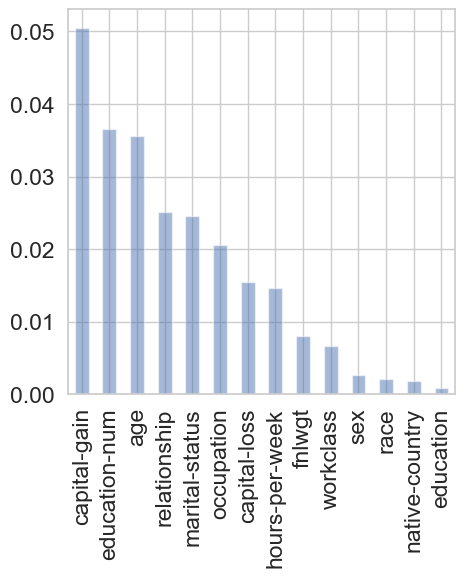

time: 187 ms (started: 2023-05-12 16:56:20 +09:00)


In [63]:
# census 모델에서 가장 크게 영향을 주는 feature 표시
show_model_explanations()

In [64]:
def generate_predictions():
    execute_sql(f"""drop table if exists census_test_predictions; """)
    execute_sql(f"""call sys.ML_PREDICT_TABLE('census.census_test', @census_model, 'census.census_test_predictions', NULL);""")
    df_all = execute_sql(f"""select revenue, ml_results from census_test_predictions;""")
    df_actual = df_all['revenue'].str.strip('.')
    df_all = pd.DataFrame(df_all['ml_results'].apply(ast.literal_eval).tolist())
    df_pred = pd.json_normalize(df_all['predictions'])
    df_proba = pd.json_normalize(df_all['probabilities'])

    return df_pred, df_actual, df_proba

df_pred, df_actual, df_proba = generate_predictions()

Running drop table if exists census_test_predictions; 
Running call sys.ML_PREDICT_TABLE('census.census_test', @census_model, 'census.census_test_predictions', NULL);
Running select revenue, ml_results from census_test_predictions;
time: 6.94 s (started: 2023-05-12 16:56:50 +09:00)


In [ ]:
df_pred.head(20), df_actual.head(20)

## 예측과 실제 결과 비교

In [65]:
from sklearn.metrics import classification_report
#print(classification_report(df_actual, df_pred, labels=['<=50K', '>50K'], target_names=['<=50K','>50K']))
print(classification_report(df_actual, df_pred))   # 정확도, 정밀도, 재현율, f1-score

              precision    recall  f1-score   support

       <=50K       0.90      0.94      0.92     12435
        >50K       0.77      0.65      0.71      3846

    accuracy                           0.87     16281
   macro avg       0.83      0.80      0.81     16281
weighted avg       0.87      0.87      0.87     16281

time: 2.83 s (started: 2023-05-12 16:57:43 +09:00)


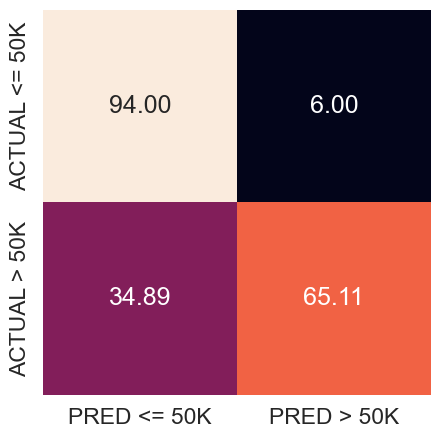

time: 136 ms (started: 2023-05-12 16:58:31 +09:00)


In [66]:
# census에 개인별 소득 예측과 실제 결과 비교 (모델 성과 지표가 되는 f1-score 기반이 됨. 정밀도와 재현율로 계산이 됨)

from sklearn.metrics import confusion_matrix
import numpy as np

def generate_confusion_matrix(pred, actual):
    cm = confusion_matrix(actual, pred)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    df_cm = pd.DataFrame(cm)
    df_cm = df_cm * 100
    plt.figure(figsize=(5,5))
    sns.heatmap(df_cm, annot=True, fmt='.2f', cbar=False, xticklabels=['PRED <= 50K', 'PRED > 50K'], yticklabels=['ACTUAL <= 50K', 'ACTUAL > 50K'])


generate_confusion_matrix(df_pred, df_actual)



## 실제 row 데이터로 데이터 예측 수행

In [67]:
execute_sql(f"""set @row_data = JSON_OBJECT(
\"age\", 25,
\"workclass\", \"Private\",
\"fnlwgt\", 89814, 
\"education\", \"HS-grad\",
\"education-num\", 9,
\"marital-status\", \"Married-civ-spouse\",
\"occupation\", \"Machine-op-inspect\",
\"relationship\", \"Husband\",
\"race\", \"White\",
\"sex\", \"Male\",
\"capital-gain\", 0,
\"capital-loss\", 0,
\"hours-per-week\", 50,
\"native-country\", \"United-States\"
);""")

Running set @row_data = JSON_OBJECT(
"age", 25,
"workclass", "Private",
"fnlwgt", 89814,
"education", "HS-grad",
"education-num", 9,
"marital-status", "Married-civ-spouse",
"occupation", "Machine-op-inspect",
"relationship", "Husband",
"race", "White",
"sex", "Male",
"capital-gain", 0,
"capital-loss", 0,
"hours-per-week", 50,
"native-country", "United-States"
);


""


time: 21.7 ms (started: 2023-05-12 17:03:49 +09:00)


In [68]:
row_pred_result = execute_sql(f"""select sys.ML_PREDICT_ROW(@row_data, @census_model, NULL);""").iat[0,0]
pd.Series(json.loads(row_pred_result))

Running select sys.ML_PREDICT_ROW(@row_data, @census_model, NULL);


age                                                                                                     25
sex                                                                                                   Male
race                                                                                                 White
fnlwgt                                                                                               89814
education                                                                                          HS-grad
workclass                                                                                          Private
Prediction                                                                                           <=50K
ml_results        {"predictions": {"revenue": " <=50K"}, "probabilities": {" <=50K": 0.91, " >50K": 0.09}}
occupation                                                                              Machine-op-inspect
capital-gain                         

time: 178 ms (started: 2023-05-12 17:03:52 +09:00)


In [69]:
row_exp_result = execute_sql(f"""select sys.ML_EXPLAIN_ROW(@row_data, @census_model, JSON_OBJECT('prediction_explainer','permutation_importance'));""")
pd.Series(json.loads(row_exp_result.values[0][0]))

Running select sys.ML_EXPLAIN_ROW(@row_data, @census_model, JSON_OBJECT('prediction_explainer','permutation_importance'));


age                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      25
sex                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

time: 5.01 s (started: 2023-05-12 17:03:55 +09:00)


2023-05-12 17:11:53,563| ERROR   | Socket exception: Operation timed out (60)
